##Introduccion

La penisilina es unos de los recursos mas usados cuando se trata de combatir enfermedades bacterianas, producido por el hongo Penicillium notatum, demostró una capacidad extraordinaria para eliminar una amplia gama de bacterias patógenas sin dañar significativamente a las células humanas. Su mecanismo de acción se basa en la inhibición de la síntesis de la pared celular bacteriana, específicamente al interferir con las enzimas transpeptidasas (llamadas Proteínas Fijadoras de Penicilina o PBP), lo que provoca la lisis y muerte de la célula bacteriana.

Sin embargo, el uso clínico masivo y, en muchos casos, indiscriminado de la penicilina, tanto en medicina humana como en la agricultura y la ganadería, generó una presión selectiva sin precedentes sobre las poblaciones bacterianas. Este fenómeno se convirtió en un claro ejemplo de la teoría de la evolución por selección natural: aquellas bacterias que, por mutaciones genéticas espontáneas o por la adquisición de material genético de otras bacterias, poseían mecanismos para evadir la acción del antibiótico, sobrevivieron y se multiplicaron. Con el tiempo, estas cepas resistentes se diseminaron globalmente, dando lugar a un problema de salud pública cada vez más grave.

Las bacterias mismas generaron enzimas  (principalmente las clasificadas como Class A β-lactamases como TEM y SHV en la ontología CARD) que hidrolizan el anillo β-lactámico de la penicilina, inactivando el antibiótico. Este es el mecanismo de resistencia más común y extendido.


Una de las propuesta que hago aplicando los usos de la bioinformatica y usando las bases de datos de https://card.mcmaster.ca/home es usar algoritmos de aprendizajes como Random Forest, MLP, desicion tree, similar a lo realizado en miniproyecto 2 para poder ver si es posible detectar la resistencia de las bacterias con el genoma mismo

Referencia: The Comprehensive Antibiotic Resistance Database
DOI:10.1128/aac.00419-13


##Instalacion  e importacion de bibliotecas

In [1]:
!pip install biopython

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.2/3.2 MB 23.4 MB/s eta 0:00:00


Este comando instala la librería Biopython, que es esencial para trabajar con datos biológicos, especialmente para leer y manipular archivos en formato FASTA que contienen las secuencias de ADN

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
import random

# Importaciones de BioPython
from Bio import SeqIO
from Bio.Seq import Seq

# Importaciones de Scikit-learn
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.decomposition import PCA

##Este caso usaremos dos data sets aro_index.tsv  el cual lo usaremos tanto para entender el dataset entero, como las etiquetas para poder entrenar la IA  y sepa cual es resitente y cual no, mientras que el archivo nucleotide_fasta_protein_homolog_model.fasta es la base  la cual se usa para entrenar el modelo por completo, en base a codones de los nucleotidos  hacemos que entienda como distinguir en base a los mismos

##Carga y analisis del Dataset

Muestra del dataset de etiquetas:


,ARO Accession,CVTERM ID,Model Sequence ID,Model ID,Model Name,ARO Name,Protein Accession,DNA Accession,AMR Gene Family,Drug Class,Resistance Mechanism,CARD Short Name
0,ARO:3005099,43314,6143,3831,23S rRNA (adenine(2058)-N(6))-methyltransferas...,23S rRNA (adenine(2058)-N(6))-methyltransferas...,AAB60941.1,AF002716.1,Erm 23S ribosomal RNA methyltransferase,lincosamide antibiotic;macrolide antibiotic;st...,antibiotic target alteration,Spyo_ErmA_MLSb
1,ARO:3002523,38923,8144,1781,AAC(2')-Ia,AAC(2')-Ia,AAA03550.1,L06156.2,AAC(2'),aminoglycoside antibiotic,antibiotic inactivation,AAC(2')-Ia
2,ARO:3002524,38924,85,746,AAC(2')-Ib,AAC(2')-Ib,AAC44793.1,U41471.1,AAC(2'),aminoglycoside antibiotic,antibiotic inactivation,AAC(2')-Ib
3,ARO:3002525,38925,4719,1246,AAC(2')-Ic,AAC(2')-Ic,CCP42991.1,AL123456.3,AAC(2'),aminoglycoside antibiotic,antibiotic inactivation,AAC(2')-Ic
4,ARO:3002526,38926,228,1415,AAC(2')-Id,AAC(2')-Id,AAB41701.1,U72743.1,AAC(2'),aminoglycoside antibiotic,antibiotic inactivation,AAC(2')-Id


/tmp/ipython-input-2452712058.py:16: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=resistance_counts_binary.index, y=resistance_counts_binary.values, palette="viridis")


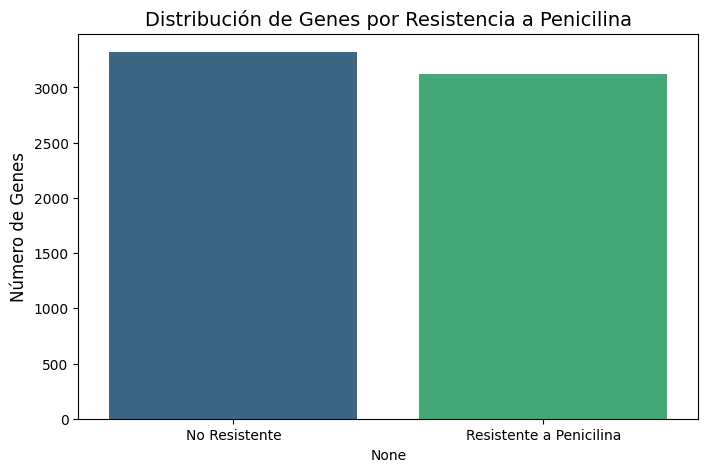


Las 20 clases de medicamentos más frecuentes son: ['cephalosporin', 'penicillin beta-lactam', 'carbapenem', 'monobactam', 'fluoroquinolone antibiotic', 'aminoglycoside antibiotic', 'peptide antibiotic', 'tetracycline antibiotic', 'macrolide antibiotic', 'glycopeptide antibiotic', 'phenicol antibiotic', 'lincosamide antibiotic', 'streptogramin antibiotic', 'diaminopyrimidine antibiotic', 'glycylcycline', 'disinfecting agents and antiseptics', 'streptogramin A antibiotic', 'streptogramin B antibiotic', 'nucleoside antibiotic', 'rifamycin antibiotic']


In [3]:
# Cargar el dataset de etiquetas
df_full_dataset = pd.read_csv("aro_index.tsv", sep='\t')
print("Muestra del dataset de etiquetas:")
display(df_full_dataset.head())

# --- Análisis 1: Resistencia a Penicilina (Binario) ---
def is_penicillin_resistant(drug_class):
    if isinstance(drug_class, str) and ('penicillin beta-lactam' in drug_class.lower() or 'beta-lactam' in drug_class.lower()):
        return 1
    return 0
df_full_dataset['is_resistant_to_penicillin'] = df_full_dataset['Drug Class'].apply(is_penicillin_resistant)
resistance_counts_binary = df_full_dataset['is_resistant_to_penicillin'].value_counts()
resistance_counts_binary.index = ['No Resistente', 'Resistente a Penicilina']

plt.figure(figsize=(8, 5))
sns.barplot(x=resistance_counts_binary.index, y=resistance_counts_binary.values, palette="viridis")
plt.title('Distribución de Genes por Resistencia a Penicilina', fontsize=14)
plt.ylabel('Número de Genes', fontsize=12)
plt.show()

# --- Análisis 2: Clases de Antibióticos (Multilabel) ---
# Identificar las 5 clases más frecuentes para nuestro modelo
drug_classes_series = df_full_dataset['Drug Class'].dropna()
all_classes_list = [item.strip() for sublist in drug_classes_series.str.split(';').tolist() for item in sublist]
class_counts = Counter(all_classes_list)
top_n = 20
top_drug_classes = [class_name for class_name, count in class_counts.most_common(top_n)]

print(f"\nLas {top_n} clases de medicamentos más frecuentes son: {top_drug_classes}")

# Crear columnas temporales para el gráfico
Y_multi_label_graph = pd.DataFrame(index=df_full_dataset.index)
renamed_top_drug_classes_graph = []
for class_name in top_drug_classes:
    col_name = class_name.replace(' ', '_').replace('-', '_')
    Y_multi_label_graph[col_name] = df_full_dataset['Drug Class'].apply(lambda x: 1 if isinstance(x, str) and class_name in x else 0)
    renamed_top_drug_classes_graph.append(col_name)

resistance_counts_graph = Y_multi_label_graph[renamed_top_drug_classes_graph].sum().sort_values(ascending=False)

Aqui vemos en como esta distribuido el dataset en base la medicina principial, peniclin beta lactam, con ello vemos que hay una cantidad similar de datos tanto en resistentes como no resistentes del mismo, nos damos cuenta que la diferencia que tienen no es relevante en si  para el entrenamiento de datasets en base la resistencia principal

/tmp/ipython-input-954904623.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=resistance_counts_graph.index, y=resistance_counts_graph.values, palette="viridis")


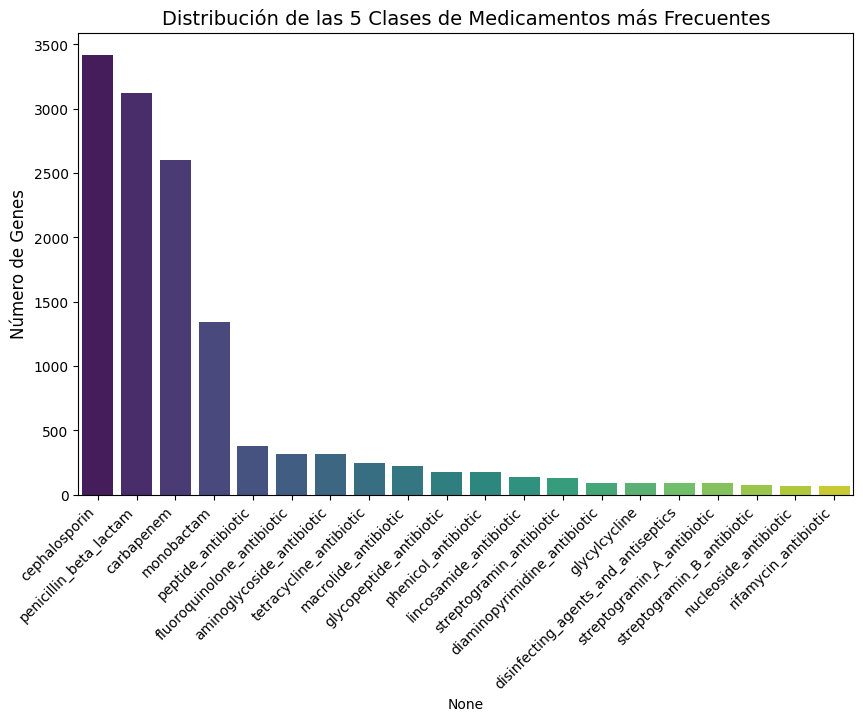

In [4]:
# Visualizar la distribución de las 5 clases principales
plt.figure(figsize=(10, 6))
sns.barplot(x=resistance_counts_graph.index, y=resistance_counts_graph.values, palette="viridis")
plt.title('Distribución de las 5 Clases de Medicamentos más Frecuentes', fontsize=14)
plt.ylabel('Número de Genes', fontsize=12)
plt.xticks(rotation=45, ha='right')
plt.show()

En profundidad  viendo el data set, vemos que se registran la mayoria de las resistencia, para el entrenamiento y algunos estan  con un registro de menos de 500 muestras. Realmente en el datasets no hay bacterias sin resistencia, la mayoria tienen un tipo de resistencia minimo, lo cual dificulta un analisis de cuales son y cuales no, para ello lo que haremos es  limitar a 4 tipos de resistencia, para poder limitarlo para un entrenamiento mas centrado y ademas poder probar mediante este metodo  el ingresar  fragmentos de esos genomas y lograr ver si predice.

El motivo por el cual no hice el mismo analisis del archivo FASTA se debe que para mi, como analista de datos seria irrelevante ello, no sacaria ningun tipo de dato relevante para saber como enfocar la solucion de la problematica que planteo resolver, los modelos directamente los entrenaria con los genomas  y las caracteristiscas de cada uno, como sus resistencias, cosa que hice arriba si son cruciales mirarlos

##Arreglo del archivo FASTA

Los archivos FASTA a menudo incluyen caracteres además de 'A', 'T', 'C' y 'G' (como 'N' para "desconocido", 'Y' para "Pirimidina", o 'S' para "G o C"), los cuales no pueden ser procesados directamente por los modelos de machine learning, esto debido que los genomas debe de ser los peptidos de los ATCG para que el aprendizaje sea correcto. Para solucionar esto, el script primero analiza el archivo FASTA original (nucleotide_fasta_protein_homolog_model.fasta) para calcular la distribución de probabilidad de los cuatro nucleótidos válidos. Esto crea un perfil de referencia que indica la frecuencia natural de A, T, C y G en el conjunto de datos (ej. 30% A, 28% T, 21% C, 21% G).

Una vez calculada esta distribución,selecciona aleatoriamente 'A', 'T', 'C' o 'G' basándose en la probabilidad calculada en el paso anterior.

Todas las secuencias limpias, ahora compuestas exclusivamente por ATCG y en mayúsculas, se guardan en un nuevo archivo (_modified.fasta). Finalmente, el script incluye un paso de verificación que lee este nuevo archivo para confirmar que la limpieza fue exitosa y que los datos están listos para la siguiente etapa de extracción de características (k-mers).

In [5]:
# --- Funciones de Ayuda para FASTA ---

def calculate_nucleotide_probability(fasta_file):
    # Calcula la frecuencia de ATCG en el archivo FASTA.
    nucleotide_counts = Counter()
    valid_nucleotides = set("ATCGatcg")
    for record in SeqIO.parse(fasta_file, "fasta"):
        for char in str(record.seq):
            if char in valid_nucleotides:
                nucleotide_counts[char.upper()] += 1

    total_nucleotides = sum(nucleotide_counts.values())
    if total_nucleotides == 0:
        # Fallback por si el archivo está vacío o no tiene ATCG
        return {'A': 0.25, 'T': 0.25, 'C': 0.25, 'G': 0.25}

    probability = {n: count / total_nucleotides for n, count in nucleotide_counts.items()}
    print("Distribución de probabilidad de nucleótidos:")
    print(probability)
    return probability

def replace_invalid_chars(sequence, prob_dist):
    # Reemplaza caracteres no-ATCG basado en la distribución de probabilidad.
    valid_nucleotides_upper = "ATCG"
    prob_keys = list(prob_dist.keys())
    prob_weights = list(prob_dist.values())

    modified_sequence = []
    for char in sequence:
        if char.upper() not in valid_nucleotides_upper:
            # Si no es ATCG, elige uno al azar según la probabilidad
            chosen_nucleotide = random.choices(prob_keys, weights=prob_weights, k=1)[0]
            modified_sequence.append(chosen_nucleotide)
        else:
            modified_sequence.append(char.upper()) # Aseguramos mayúsculas
    return "".join(modified_sequence)

fasta_file_original = "nucleotide_fasta_protein_homolog_model.fasta"
fasta_file_modificado = "nucleotide_fasta_protein_homolog_model_modified.fasta"

# 1. Calcular probabilidades
nucleotide_probability = calculate_nucleotide_probability(fasta_file_original)

# 2. Procesar y guardar el nuevo archivo FASTA
modified_records = []
processed_count = 0
for record in SeqIO.parse(fasta_file_original, "fasta"):
    sequence = str(record.seq)
    modified_sequence_str = replace_invalid_chars(sequence, nucleotide_probability)

    # Creamos un nuevo registro con la secuencia limpia
    new_record = SeqIO.SeqRecord(
        Seq(modified_sequence_str),
        id=record.id,
        description=record.description
    )
    modified_records.append(new_record)
    processed_count += 1

with open(fasta_file_modificado, "w") as output_handle:
    SeqIO.write(modified_records, output_handle, "fasta")

# 3. Verificar el archivo modificado
valid_set = set("ATCG")
invalid_found = False
for record in SeqIO.parse(fasta_file_modificado, "fasta"):
    sequence_chars = set(str(record.seq))
    if not sequence_chars.issubset(valid_set):
        invalid_chars = list(sequence_chars - valid_set)
        print(f"  ¡Error! ID: {record.id} contiene caracteres inválidos: {invalid_chars}")
        invalid_found = True

if not invalid_found:
    print("¡Éxito! Todas las secuencias en el archivo modificado contienen solo ATCG.")

Distribución de probabilidad de nucleótidos:
{'A': 0.25531420636213237, 'T': 0.22573294816516515, 'G': 0.26418861810919003, 'C': 0.25476422736351245}
¡Éxito! Todas las secuencias en el archivo modificado contienen solo ATCG.


##Generacion de codones

Transformo el conjunto de datos de secuencias genéticas crudas en una matriz numérica. En lugar de letras, el modelo de machine learning ahora verá un perfil de frecuencia ,un "vector", para cada gen, listo para ser fusionado con las etiquetas de resistencia y utilizado para el entrenamiento.

In [6]:
def count_kmers(sequence, k):
    """Cuenta k-mers en una secuencia de nucleótidos."""
    # Cuenta k-mers en una secuencia de nucleótidos.
    kmers = {}
    for i in range(len(sequence) - k + 1):
        kmer = str(sequence[i : i + k]) # Ya están en mayúsculas
        kmers[kmer] = kmers.get(kmer, 0) + 1
    return kmers

k_value = 3
sequence_kmer_counts = []

print(f"Extrayendo {k_value}-mers del archivo FASTA modificado...")
# Extrayendo
for record in SeqIO.parse(fasta_file_modificado, "fasta"):
    try:
        # Extraer el 'ARO Accession' de la cabecera
        aro_accession = None
        parts = record.id.split('|')
        for part in parts:
            if part.startswith('ARO:'):
                aro_accession = part
                break

        if aro_accession:
            sequence = record.seq
            kmer_counts = count_kmers(sequence, k_value)
            sequence_kmer_counts.append({'ARO Accession': aro_accession, 'kmer_counts': kmer_counts})

    except Exception as e:
        print(f"Error procesando ID: {record.id}. Error: {e}")
        # Error procesando ID: Error:
        continue

print(f"Procesadas {len(sequence_kmer_counts)} secuencias.")
# Procesadas secuencias.

# Convertir la lista de conteos de k-mers en un DataFrame
print("Creando DataFrame de características (X)...")
# Creando DataFrame de características (X)...
kmer_df_list = []
for item in sequence_kmer_counts:
    kmer_data = {'ARO Accession': item['ARO Accession']}
    kmer_data.update(item['kmer_counts'])
    kmer_df_list.append(kmer_data)

kmer_df = pd.DataFrame(kmer_df_list)
kmer_df = kmer_df.fillna(0) # Rellenar k-mers faltantes con 0

print("Muestra del DataFrame de K-mers (Características X):")
# Muestra del DataFrame de K-mers (Características X):
display(kmer_df.head())
print(f"Dimensiones de las características: {kmer_df.shape}")
# Dimensiones de las características:

Extrayendo 3-mers del archivo FASTA modificado...
Procesadas 6052 secuencias.
Creando DataFrame de características (X)...
Muestra del DataFrame de K-mers (Características X):


,ARO Accession,ATG,TGA,GAA,AAA,AAG,AGC,GCA,CAT,ATA,...,AGA,GTT,GGT,AGG,GAG,TAA,ACG,CGA,CCC,GTG
0,ARO:3002999,29,20,18,25.0,17.0,14.0,21,23.0,21.0,...,17.0,8.0,9.0,11.0,11.0,4.0,11.0,15.0,11.0,5.0
1,ARO:3001109,12,17,13,14.0,8.0,28.0,20,9.0,7.0,...,5.0,5.0,10.0,4.0,10.0,7.0,13.0,20.0,17.0,12.0
2,ARO:3002867,16,13,21,19.0,16.0,2.0,4,7.0,21.0,...,20.0,11.0,8.0,10.0,11.0,13.0,3.0,4.0,0.0,4.0
3,ARO:3001989,14,18,12,15.0,10.0,20.0,27,7.0,8.0,...,18.0,8.0,14.0,6.0,15.0,7.0,21.0,19.0,7.0,20.0
4,ARO:3002356,20,16,7,3.0,10.0,17.0,23,11.0,5.0,...,5.0,9.0,19.0,8.0,6.0,0.0,8.0,17.0,19.0,12.0


Dimensiones de las características: (6052, 65)


Aqui vemos a las bacterias  y su distribucion de los codones en cada unas de las mismas del data set

##Preparacion del data frame

In [7]:
# 1. Preparar las etiquetas (Y)
# Usamos el DataFrame cargado
df_genes_labels = df_full_dataset

desired_classes_labels = ['cephalosporin', 'penicillin beta-lactam', 'carbapenem', 'monobactam'] # Nombre de clase corregido
target_columns = [c.replace(' ', '_').replace('-', '_') for c in desired_classes_labels]

Y_multi_label = pd.DataFrame(index=df_genes_labels.index)
for i, class_name in enumerate(desired_classes_labels):
    col_name = target_columns[i]
    Y_multi_label[col_name] = df_genes_labels['Drug Class'].apply(
        lambda x: 1 if isinstance(x, str) and class_name in x else 0
    )

# Asignar 'ARO Accession' como índice para la fusión
Y_multi_label = Y_multi_label.set_index(df_genes_labels['ARO Accession'])

print("Muestra del DataFrame de Etiquetas (Y):")
# Muestra del DataFrame de Etiquetas (Y):
display(Y_multi_label.head())

# 2. Fusionar X e Y
merged_df = pd.merge(kmer_df, Y_multi_label, left_on='ARO Accession', right_index=True, how='inner')

print("Muestra del DataFrame fusionado:")
# Muestra del DataFrame fusionado:
display(merged_df.head())
print(f"Dimensiones del DataFrame fusionado: {merged_df.shape}")
# Dimensiones del DataFrame fusionado:

Muestra del DataFrame de Etiquetas (Y):


,cephalosporin,penicillin_beta_lactam,carbapenem,monobactam
ARO Accession,,,,
ARO:3005099,0,0,0,0
ARO:3002523,0,0,0,0
ARO:3002524,0,0,0,0
ARO:3002525,0,0,0,0
ARO:3002526,0,0,0,0


Muestra del DataFrame fusionado:


,ARO Accession,ATG,TGA,GAA,AAA,AAG,AGC,GCA,CAT,ATA,...,GAG,TAA,ACG,CGA,CCC,GTG,cephalosporin,penicillin_beta_lactam,carbapenem,monobactam
0,ARO:3002999,29,20,18,25.0,17.0,14.0,21,23.0,21.0,...,11.0,4.0,11.0,15.0,11.0,5.0,1,0,0,0
1,ARO:3001109,12,17,13,14.0,8.0,28.0,20,9.0,7.0,...,10.0,7.0,13.0,20.0,17.0,12.0,1,1,0,0
2,ARO:3002867,16,13,21,19.0,16.0,2.0,4,7.0,21.0,...,11.0,13.0,3.0,4.0,0.0,4.0,0,0,0,0
3,ARO:3001989,14,18,12,15.0,10.0,20.0,27,7.0,8.0,...,15.0,7.0,21.0,19.0,7.0,20.0,1,0,0,0
4,ARO:3002356,20,16,7,3.0,10.0,17.0,23,11.0,5.0,...,6.0,0.0,8.0,17.0,19.0,12.0,1,1,1,0


Dimensiones del DataFrame fusionado: (6054, 69)


Lo que realizamos esta seccion es la fusion de las partes importante del data set de cada uno, el archivo fasta y el archivo aro index con las etiquetas de cada ARO y sus respectivas resistencias de cada bacteria y del fasta

Comparar secuencias completas a menudo requiere alinearlas primero. Este proceso puede ser muy costoso computacionalmente, especialmente con muchos datos, y puede fallar o dar resultados pobres si las secuencias son muy diferentes o tienen partes reordenadas. Al contar solo las frecuencias de k-mers, te saltas el paso del alineamiento lo que hace el análisis mucho más rápido y más robusto ante grandes variaciones en el orden de la secuencia.

Referencia:Alignment-free sequence comparison—a review  DOI: 10.1093/bioinformatics/btg005





##Preparacion de la base de datos para el  entreno

Dividir el conjunto de datos combinado (`merged_df`) en conjuntos de entrenamiento y prueba.

GroupShuffleSplit es una herramienta de scikit-learn que se utiliza para dividir un conjunto de datos en conjuntos de entrenamiento y prueba de una manera muy específica, especialmente útil cuando tienes datos agrupados y quieres evitar la fuga de información (data leakage).

In [8]:
import pandas as pd
from sklearn.model_selection import GroupShuffleSplit

# Definir las columnas de características (todos los k-mers)
feature_columns = [col for col in kmer_df.columns if col != 'ARO Accession']
X = merged_df[feature_columns].copy()

# Y ya está definido con las 'target_columns'
Y = merged_df[target_columns].copy()

# Dividir los datos usando GroupShuffleSplit para evitar memorización
gss = GroupShuffleSplit(test_size=0.2, n_splits=1, random_state=42)
train_idx, test_idx = next(gss.split(X, Y, groups=merged_df['ARO Accession']))
X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
Y_train, Y_test = Y.iloc[train_idx], Y.iloc[test_idx]

print(f"Forma de X_train: {X_train.shape}")
print(f"Forma de Y_train: {Y_train.shape}")
print(f"Forma de X_test: {X_test.shape}")
print(f"Forma de Y_test: {Y_test.shape}")

# Verificar la distribución de clases en Y_test
print("\nDistribución de clases en Y_test:")
for col in Y_test.columns:
    print(f"{col}:\n{Y_test[col].value_counts()}")

Forma de X_train: (4842, 64)
Forma de Y_train: (4842, 4)
Forma de X_test: (1212, 64)
Forma de Y_test: (1212, 4)

Distribución de clases en Y_test:
cephalosporin:
cephalosporin
1    680
0    532
Name: count, dtype: int64
penicillin_beta_lactam:
penicillin_beta_lactam
1    610
0    602
Name: count, dtype: int64
carbapenem:
carbapenem
0    716
1    496
Name: count, dtype: int64
monobactam:
monobactam
0    951
1    261
Name: count, dtype: int64


##Entrenamiento del modelo RANDOM FOREST

--- Entrenando Modelo 1: Random Forest ---
Evaluando Random Forest...

Reporte de Clasificación (Random Forest):
                        precision    recall  f1-score   support

         cephalosporin       0.99      0.96      0.97       680
penicillin_beta_lactam       0.98      0.96      0.97       610
            carbapenem       0.99      0.95      0.97       496
            monobactam       0.99      0.99      0.99       261

             micro avg       0.99      0.96      0.97      2047
             macro avg       0.99      0.96      0.98      2047
          weighted avg       0.99      0.96      0.97      2047
           samples avg       0.79      0.78      0.78      2047



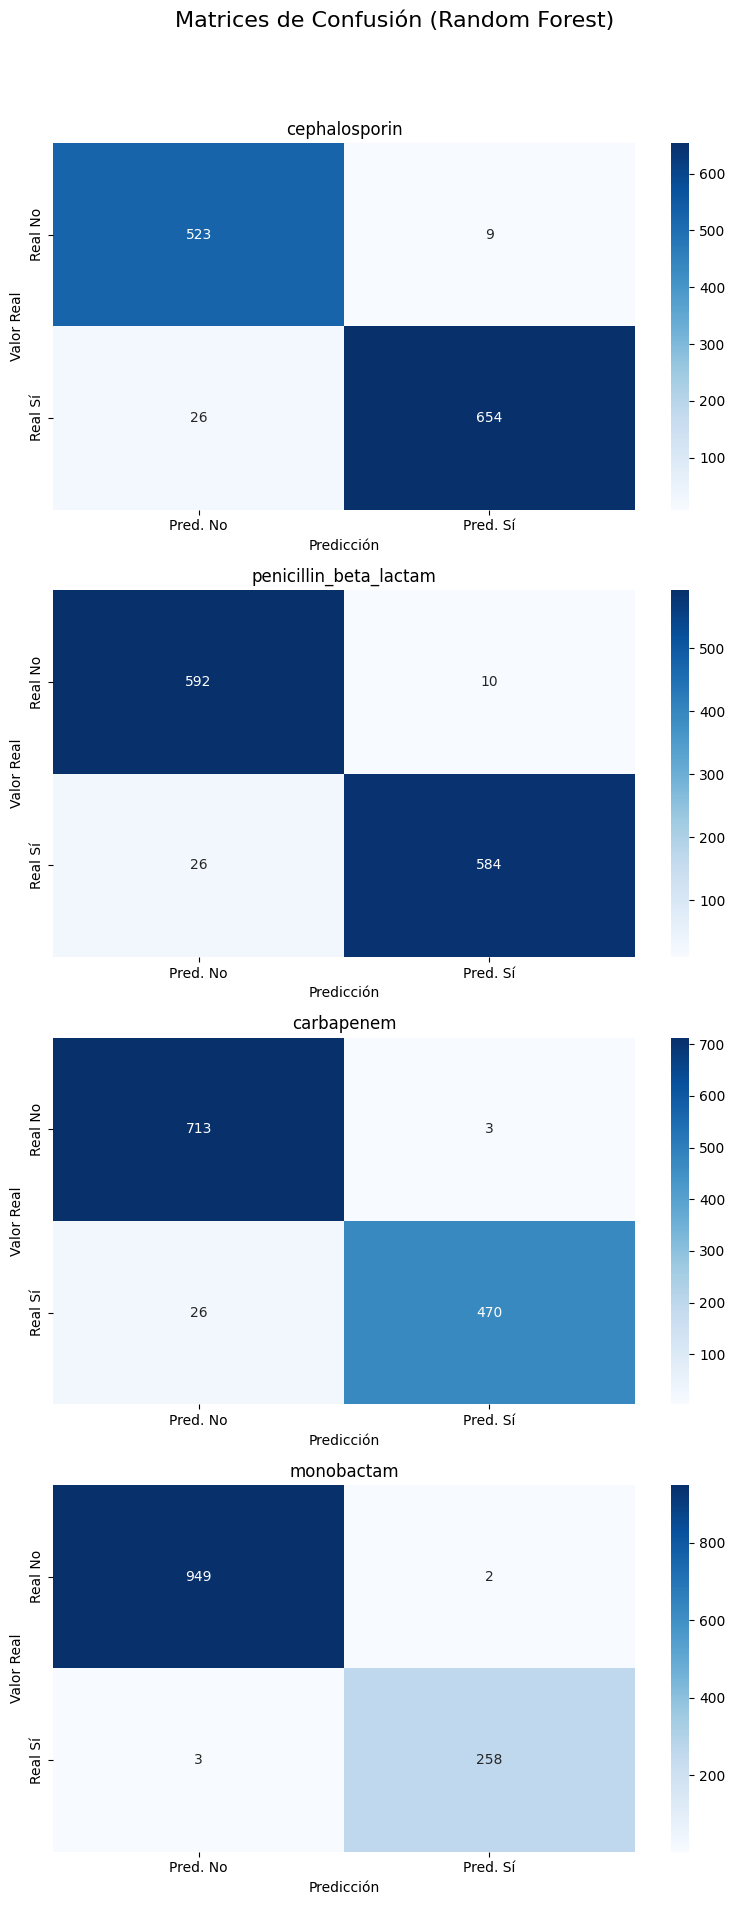

In [9]:
print("--- Entrenando Modelo 1: Random Forest ---")
# --- Entrenando Modelo 1: Random Forest ---
rf_model = RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1)
rf_model.fit(X_train, Y_train)

print("Evaluando Random Forest...")
# Evaluando Random Forest...
Y_pred_rf = rf_model.predict(X_test)

print("\nReporte de Clasificación (Random Forest):")
# Reporte de Clasificación (Random Forest):
print(classification_report(Y_test, Y_pred_rf, target_names=target_columns, zero_division=0))

# Matrices de confusión
fig, axes = plt.subplots(4, 1, figsize=(8, 20)) # Changed layout to 4 rows, 1 column, adjusted size
fig.suptitle('Matrices de Confusión (Random Forest)', fontsize=16)
# Matrices de Confusión (Random Forest)
for i, class_name in enumerate(target_columns):
    cm = confusion_matrix(Y_test.iloc[:, i], Y_pred_rf[:, i])
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=axes[i],
                xticklabels=['Pred. No', 'Pred. Sí'],
                yticklabels=['Real No', 'Real Sí'])
    axes[i].set_title(class_name)
    axes[i].set_xlabel('Predicción')
    axes[i].set_ylabel('Valor Real')
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

##Entrenamiento del modelo DESICION TREE


--- Entrenando Modelo 2: Árbol de Decisión ---
Evaluando Árbol de Decisión...

Reporte de Clasificación (Árbol de Decisión):
                        precision    recall  f1-score   support

         cephalosporin       0.94      0.95      0.94       680
penicillin_beta_lactam       0.92      0.94      0.93       610
            carbapenem       0.92      0.92      0.92       496
            monobactam       0.95      0.99      0.97       261

             micro avg       0.93      0.94      0.94      2047
             macro avg       0.93      0.95      0.94      2047
          weighted avg       0.93      0.94      0.94      2047
           samples avg       0.76      0.77      0.76      2047



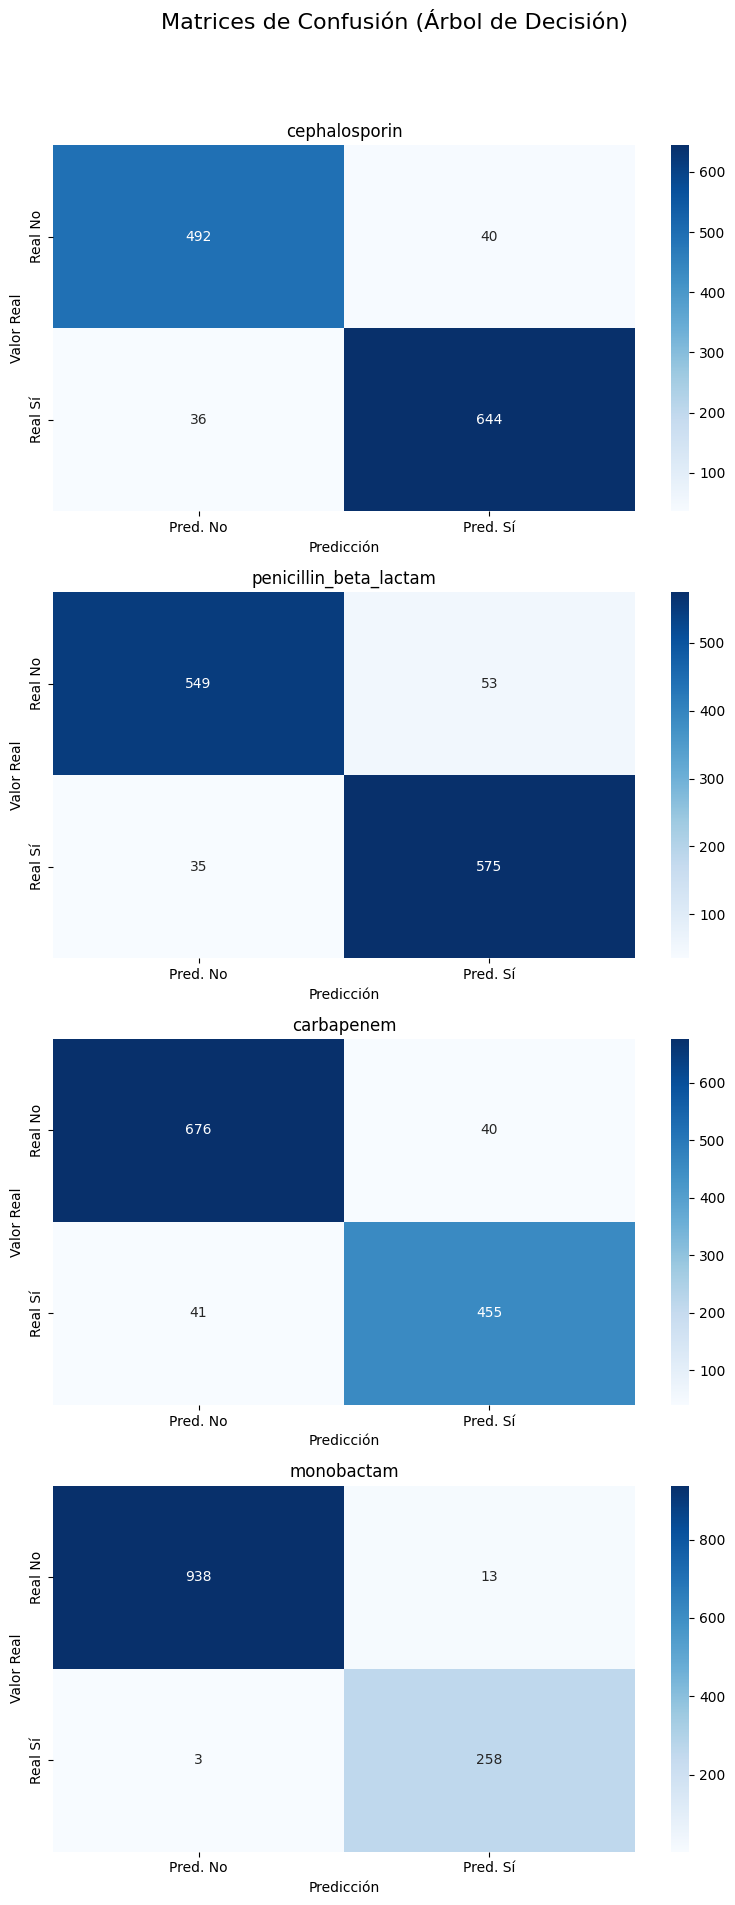

In [10]:
print("\n--- Entrenando Modelo 2: Árbol de Decisión ---")
# --- Entrenando Modelo 2: Árbol de Decisión ---
dt_model = DecisionTreeClassifier(random_state=42)
dt_model.fit(X_train, Y_train)

print("Evaluando Árbol de Decisión...")
# Evaluando Árbol de Decisión...
Y_pred_dt = dt_model.predict(X_test)

print("\nReporte de Clasificación (Árbol de Decisión):")
# Reporte de Clasificación (Árbol de Decisión):
print(classification_report(Y_test, Y_pred_dt, target_names=target_columns, zero_division=0))

# Matrices de confusión para Árbol de Decisión
fig, axes = plt.subplots(4, 1, figsize=(8, 20)) # Changed layout to 4 rows, 1 column, adjusted size
fig.suptitle('Matrices de Confusión (Árbol de Decisión)', fontsize=16)
for i, class_name in enumerate(target_columns):
    cm = confusion_matrix(Y_test.iloc[:, i], Y_pred_dt[:, i])
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=axes[i],
                xticklabels=['Pred. No', 'Pred. Sí'],
                yticklabels=['Real No', 'Real Sí'])
    axes[i].set_title(class_name)
    axes[i].set_xlabel('Predicción')
    axes[i].set_ylabel('Valor Real')
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

##Entrenamiento del modelo MLP


--- Entrenando Modelo 3: Red Neuronal (MLP) ---
Evaluando Red Neuronal (MLP)...

Reporte de Clasificación (MLP):
                        precision    recall  f1-score   support

         cephalosporin       0.97      0.97      0.97       680
penicillin_beta_lactam       0.96      0.95      0.96       610
            carbapenem       0.96      0.95      0.96       496
            monobactam       0.98      0.97      0.98       261

             micro avg       0.97      0.96      0.96      2047
             macro avg       0.97      0.96      0.96      2047
          weighted avg       0.97      0.96      0.96      2047
           samples avg       0.78      0.79      0.78      2047



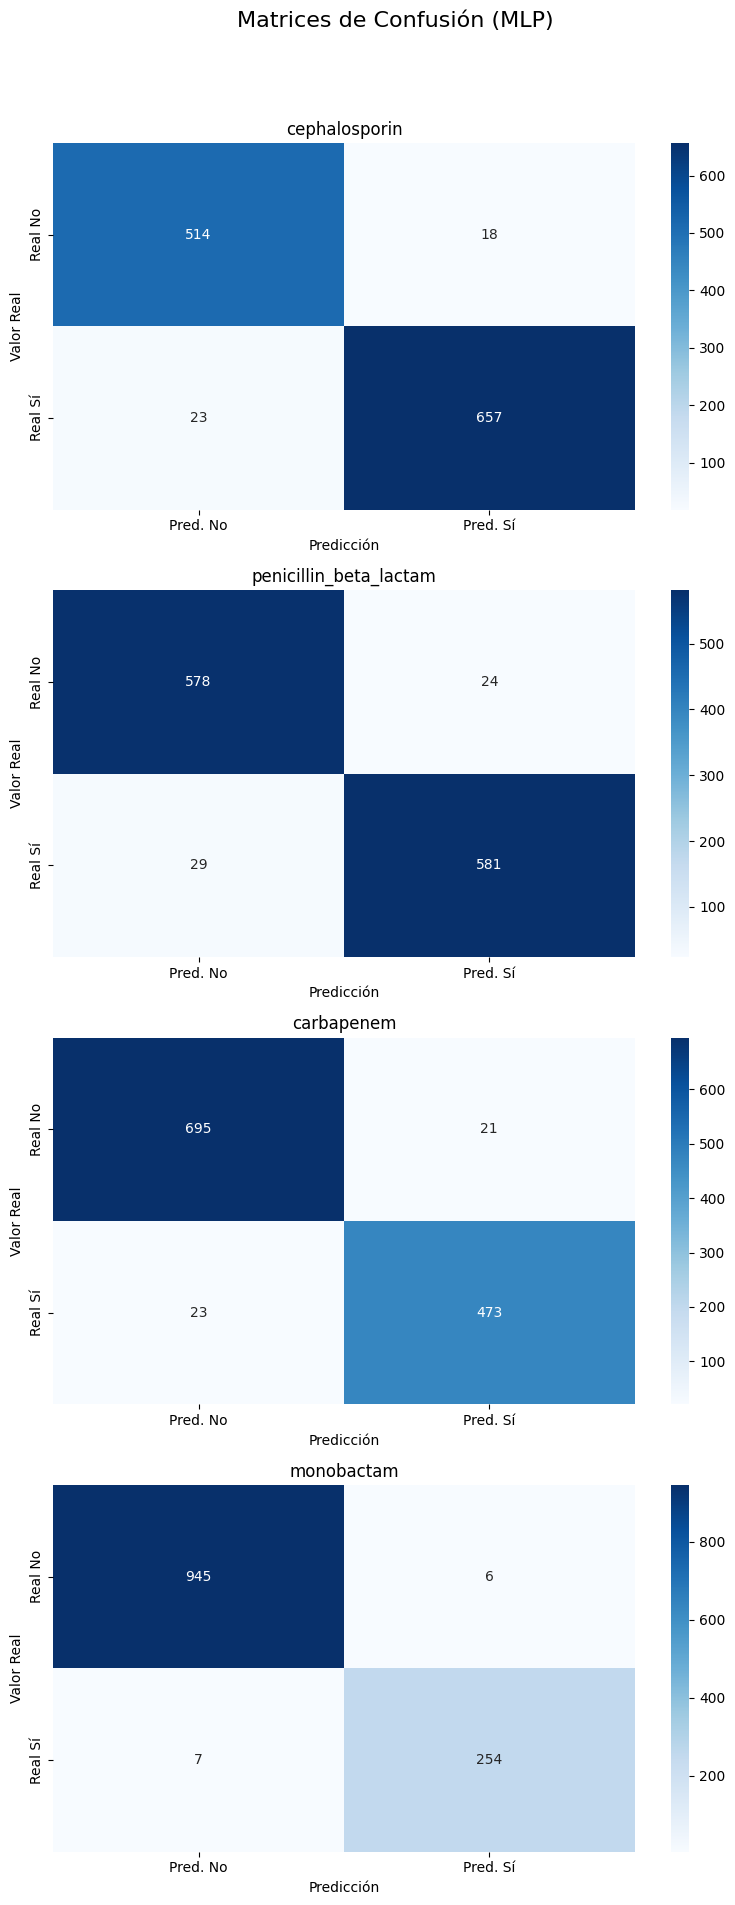

In [11]:
print("\n--- Entrenando Modelo 3: Red Neuronal (MLP) ---")
# --- Entrenando Modelo 3: Red Neuronal (MLP) ---
# Escalar los datos para el MLP
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

mlp_model = MLPClassifier(random_state=42, max_iter=500, hidden_layer_sizes=(100, 50, 25), early_stopping=True)
mlp_model.fit(X_train_scaled, Y_train)

print("Evaluando Red Neuronal (MLP)...")
# Evaluando Red Neuronal (MLP)...
Y_pred_mlp = mlp_model.predict(X_test_scaled)

print("\nReporte de Clasificación (MLP):")
# Reporte de Clasificación (MLP):
print(classification_report(Y_test, Y_pred_mlp, target_names=target_columns, zero_division=0))

# Matrices de confusión para MLP
fig, axes = plt.subplots(4, 1, figsize=(8, 20)) # Changed layout to 4 rows, 1 column, adjusted size
fig.suptitle('Matrices de Confusión (MLP)', fontsize=16)
for i, class_name in enumerate(target_columns):
    cm = confusion_matrix(Y_test.iloc[:, i], Y_pred_mlp[:, i])
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=axes[i],
                xticklabels=['Pred. No', 'Pred. Sí'],
                yticklabels=['Real No', 'Real Sí'])
    axes[i].set_title(class_name)
    axes[i].set_xlabel('Predicción')
    axes[i].set_ylabel('Valor Real')
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

##Resutlados de los predictores:

Entre los modelos utilizados para la obtencion del mejor modelos, es para Random forest con un accuracy de promedio entre los 4 medicamentos del 98%, ganando de manera contundente ante los otros modelos

Random Forest fue el mejor porque:

**Reduce el sobreajuste**: Combina muchos árboles de decisión, lo que evita que el modelo memorice los datos de entrenamiento y mejora su capacidad para predecir en datos nuevos.

**Más preciso y robusto**: Al promediar las predicciones de múltiples árboles, ofrece resultados más estables y exactos que un solo árbol o una red neuronal MLP que puede ser más sensible a la configuración.

**Maneja bien muchos datos**: Es eficiente con las muchas características (k-mers) generadas por los genomas.



Esto no quita el hecho de la presicion que obtuvieron los demas modelos son prometedores, pero hay que admitir que el random forest fue el mejor

##.
Probando con esta combinacion de los data sets, nos da que el predictor de resistencia a antibioticos es muy prometedor al momento de detcectar, teniendo una cantidad despreciable de falsos positivos  a comparacion de sus aciertos, siendo mayor el numeor con los falsos positivos de resistentes que les predijo como no resistentes de carbapenem
Los valores de la Puntuación F1 superiores a $0.95$ confirman que el modelo identifica eficazmente los genes $\beta$-Lactamasas. Las altas métricas para Penicilina, Cefalosporina, Carbapenem y Monobactam son una manifestación directa de la Resistencia Cruzada: la misma enzima (la $\beta$-Lactamasa)  inactiva a múltiples antibióticos con la misma estructura química.


##Prueba de el modelo random forest

#Ensayo de predicciones con parte de los genomas

Unas de las propuestas  que quise agregar, es la capacidad de predecir mediante fragmentos del genoma  

In [12]:
print("\n--- Ensayo con Fragmentos de Genomas y Predicción con Random Forest (usando X_test) ---")

# --- Funciones de Ayuda (redefinidas para consolidación) ---
def get_random_fragment(sequence_str, fragment_length=500):
    """Genera un fragmento aleatorio de una secuencia. Si la secuencia es más corta, devuelve la secuencia completa."""
    if len(sequence_str) <= fragment_length:
        return sequence_str
    start_index = random.randint(0, len(sequence_str) - fragment_length)
    return sequence_str[start_index : start_index + fragment_length]

def count_kmers(sequence, k):
    """Cuenta k-mers en una secuencia de nucleótidos."""
    kmers = {}
    for i in range(len(sequence) - k + 1):
        kmer = str(sequence[i : i + k])
        kmers[kmer] = kmers.get(kmer, 0) + 1
    return kmers

# --- Definir variables faltantes o actualizar para usar X_test ---
num_samples = 10 # Número de muestras a tomar del conjunto de prueba para este experimento específico.

# Obtener los ARO Accessions que corresponden a los índices de X_test
# El índice de X_test corresponde al índice original de merged_df.
# Necesitamos mapear estos índices de vuelta a 'ARO Accession' desde merged_df.
test_set_merged_indices = X_test.index
test_set_accessions = merged_df.loc[test_set_merged_indices, 'ARO Accession'].tolist()

# Seleccionar 'num_samples' ARO Accessions aleatoriamente del conjunto de prueba
selected_aro_accessions = random.sample(test_set_accessions, min(num_samples, len(test_set_accessions)))

# Crear un mapeo temporal entre ARO Accession y el índice original de merged_df
merged_accession_to_index = merged_df[['ARO Accession']].copy()
merged_accession_to_index['original_index'] = merged_df.index

# Asegurar que target_columns esté definido (debería estarlo desde celdas anteriores)
target_drug_columns = target_columns

# Cargar todas las secuencias del archivo FASTA modificado (asumimos que ya está cargado)
fasta_sequences_dict = SeqIO.to_dict(SeqIO.parse(fasta_file_modificado, "fasta"))

fragment_kmer_data = []
fragment_accessions_for_output = [] # Almacenará los ARO Accessions que realmente se procesaron

# Generar y procesar fragmentos aleatorios para los AROs seleccionados
for accession in selected_aro_accessions:
    fasta_record = None
    # Buscar el registro correspondiente en el diccionario FASTA cargado.
    # El ID del registro FASTA puede contener más que solo 'ARO:XXX'.
    found_fasta_key = None
    for fasta_key, record in fasta_sequences_dict.items():
        if accession in fasta_key:
            found_fasta_key = fasta_key
            fasta_record = record
            break

    if fasta_record is None:
        print(f"Advertencia: No se encontró la secuencia completa para el ARO Accession {accession} en el archivo FASTA modificado. Saltando.")
        continue # Saltar al siguiente accession si no se encuentra la secuencia

    full_sequence = str(fasta_record.seq)
    # *** MODIFICACIÓN: Usar get_targeted_fragment en lugar de get_random_fragment ***
    # Asegurarse de que important_kmers_set esté definido en un celda anterior.
    # Si no lo está, se usará get_random_fragment como fallback o se lanzará un error.
    if 'important_kmers_set' in globals() and get_targeted_fragment.__name__ == 'get_targeted_fragment':
        random_fragment = get_targeted_fragment(full_sequence, fragment_length=500, important_kmers=important_kmers_set)
    else:
        random_fragment = get_random_fragment(full_sequence, fragment_length=500)

    fragment_kmers = count_kmers(random_fragment, k_value)

    fragment_kmer_data.append(fragment_kmers)
    fragment_accessions_for_output.append(accession) # Añadir solo si se procesó correctamente

# Convertir los k-mers de los fragmentos en un DataFrame y alinearlos con las columnas de entrenamiento
df_fragments_kmers = pd.DataFrame(fragment_kmer_data)
df_fragments_kmers = df_fragments_kmers.fillna(0)
X_fragments_aligned = df_fragments_kmers.reindex(columns=X_train.columns, fill_value=0)

# Obtener las etiquetas verdaderas de Y_test para los fragmentos procesados,
# indexándolas por ARO Accession para una fácil comparación.
processed_mapping_for_y = merged_accession_to_index[merged_accession_to_index['ARO Accession'].isin(fragment_accessions_for_output)]
Y_true_for_fragments_temp = Y_test.loc[processed_mapping_for_y['original_index'].tolist(), target_drug_columns]
Y_true_for_fragments = Y_true_for_fragments_temp.copy()
Y_true_for_fragments['ARO Accession'] = processed_mapping_for_y['ARO Accession'].values
Y_true_for_fragments = Y_true_for_fragments.set_index('ARO Accession')

print(f"Dimensiones de las características de los fragmentos: {X_fragments_aligned.shape}")
print(f"Dimensiones de las etiquetas reales de los fragmentos: {Y_true_for_fragments.shape}")

print("\n--- Realizando predicciones en los fragmentos de genomas con Random Forest ---")
predictions_fragments_rf = rf_model.predict(X_fragments_aligned)

# Crear un DataFrame para las predicciones, indexado por ARO Accession
predictions_fragments_df = pd.DataFrame(predictions_fragments_rf, columns=target_drug_columns, index=fragment_accessions_for_output)


def display_prediction_comparison(model_name, predictions_fragments_df, model_full_predictions_df, fragment_accessions, Y_true_for_fragments, target_drug_columns, merged_accession_to_index, X_test):
    print(f"\n--- Comparación Detallada: Real vs. Predicción para Fragmentos y Genoma Entero ({model_name}) ---")
    for accession in fragment_accessions:
        real_classes = [col.replace('_', ' ') for col in target_drug_columns if Y_true_for_fragments.loc[accession, col] == 1]
        predicted_classes_fragment = [col.replace('_', ' ') for col in target_drug_columns if predictions_fragments_df.loc[accession, col] == 1]

        # Obtener la predicción del genoma entero para este Accession
        original_idx = merged_accession_to_index[merged_accession_to_index['ARO Accession'] == accession]['original_index'].iloc[0]
        predicted_classes_full_genome = [col.replace('_', ' ') for col in target_drug_columns if model_full_predictions_df.loc[original_idx, col] == 1]

        print(f"\nAccession: {accession}")
        print(f"  Real (Target Classes): {real_classes if real_classes else 'Ninguna'}")
        print(f"  Predicción (Fragmento - {model_name}): {predicted_classes_fragment if predicted_classes_fragment else 'Ninguna'}")
        print(f"  Predicción (Genoma Entero - {model_name}): {predicted_classes_full_genome if predicted_classes_full_genome else 'Ninguna'}")

        # Verificar la corrección de la predicción del fragmento
        if set(real_classes) == set(predicted_classes_fragment):
            print(f"  Estado (Fragmento - {model_name}): Predicción Correcta")
        else:
            false_positives = set(predicted_classes_fragment) - set(real_classes)
            false_negatives = set(real_classes) - set(predicted_classes_fragment)
            status_parts = []
            if false_positives: status_parts.append(f"Falsos Positivos: {list(false_positives)}")
            if false_negatives: status_parts.append(f"Falsos Negativos: {list(false_negatives)}")
            print(f"  Estado (Fragmento - {model_name}): Predicción Incorrecta - {'; '.join(status_parts) if status_parts else 'Desajuste'}")

        # Verificar la corrección de la predicción del genoma entero
        if set(real_classes) == set(predicted_classes_full_genome):
            print(f"  Estado (Genoma Entero - {model_name}): Predicción Correcta")
        else:
            false_positives = set(predicted_classes_full_genome) - set(real_classes)
            false_negatives = set(real_classes) - set(predicted_classes_full_genome)
            status_parts = []
            if false_positives: status_parts.append(f"Falsos Positivos: {list(false_positives)}")
            if false_negatives: status_parts.append(f"Falsos Negativos: {list(false_negatives)}")
            print(f"  Estado (Genoma Entero - {model_name}): Predicción Incorrecta - {'; '.join(status_parts) if status_parts else 'Desajuste'}")

# --- Random Forest ---
# Realizar predicciones con Random Forest para genomas completos
Y_pred_rf_full = rf_model.predict(X_test)
Y_pred_rf_full_df = pd.DataFrame(Y_pred_rf_full, columns=target_columns, index=X_test.index)

display_prediction_comparison("Random Forest", predictions_fragments_df, Y_pred_rf_full_df, fragment_accessions_for_output, Y_true_for_fragments, target_drug_columns, merged_accession_to_index, X_test)



--- Ensayo con Fragmentos de Genomas y Predicción con Random Forest (usando X_test) ---
Dimensiones de las características de los fragmentos: (10, 64)
Dimensiones de las etiquetas reales de los fragmentos: (10, 4)

--- Realizando predicciones en los fragmentos de genomas con Random Forest ---

--- Comparación Detallada: Real vs. Predicción para Fragmentos y Genoma Entero (Random Forest) ---

Accession: ARO:3001187
  Real (Target Classes): ['cephalosporin', 'penicillin beta lactam']
  Predicción (Fragmento - Random Forest): Ninguna
  Predicción (Genoma Entero - Random Forest): ['cephalosporin', 'penicillin beta lactam']
  Estado (Fragmento - Random Forest): Predicción Incorrecta - Falsos Negativos: ['penicillin beta lactam', 'cephalosporin']
  Estado (Genoma Entero - Random Forest): Predicción Correcta

Accession: ARO:3004749
  Real (Target Classes): ['penicillin beta lactam']
  Predicción (Fragmento - Random Forest): Ninguna
  Predicción (Genoma Entero - Random Forest): Ninguna
  Esta

In [13]:

# Realizar predicciones con MLP para genomas completos (escalados)
Y_pred_mlp_full = mlp_model.predict(X_test_scaled)
Y_pred_mlp_full_df = pd.DataFrame(Y_pred_mlp_full, columns=target_columns, index=X_test.index)

# Realizar predicciones con MLP para fragmentos (escalados)
X_fragments_aligned_scaled = scaler.transform(X_fragments_aligned)
predictions_fragments_mlp = mlp_model.predict(X_fragments_aligned_scaled)
predictions_fragments_mlp_df = pd.DataFrame(predictions_fragments_mlp, columns=target_columns, index=fragment_accessions_for_output)

display_prediction_comparison("MLP", predictions_fragments_mlp_df, Y_pred_mlp_full_df, fragment_accessions_for_output, Y_true_for_fragments, target_drug_columns, merged_accession_to_index, X_test)



--- Comparación Detallada: Real vs. Predicción para Fragmentos y Genoma Entero (MLP) ---

Accession: ARO:3001187
  Real (Target Classes): ['cephalosporin', 'penicillin beta lactam']
  Predicción (Fragmento - MLP): Ninguna
  Predicción (Genoma Entero - MLP): ['cephalosporin', 'penicillin beta lactam']
  Estado (Fragmento - MLP): Predicción Incorrecta - Falsos Negativos: ['penicillin beta lactam', 'cephalosporin']
  Estado (Genoma Entero - MLP): Predicción Correcta

Accession: ARO:3004749
  Real (Target Classes): ['penicillin beta lactam']
  Predicción (Fragmento - MLP): Ninguna
  Predicción (Genoma Entero - MLP): ['monobactam']
  Estado (Fragmento - MLP): Predicción Incorrecta - Falsos Negativos: ['penicillin beta lactam']
  Estado (Genoma Entero - MLP): Predicción Incorrecta - Falsos Positivos: ['monobactam']; Falsos Negativos: ['penicillin beta lactam']

Accession: ARO:3009074
  Real (Target Classes): ['cephalosporin', 'penicillin beta lactam', 'monobactam']
  Predicción (Fragmento -

In [14]:

# Realizar predicciones con Árbol de Decisión para genomas completos
Y_pred_dt_full = dt_model.predict(X_test)
Y_pred_dt_full_df = pd.DataFrame(Y_pred_dt_full, columns=target_columns, index=X_test.index)

# Realizar predicciones con Árbol de Decisión para fragmentos
predictions_fragments_dt = dt_model.predict(X_fragments_aligned)
predictions_fragments_dt_df = pd.DataFrame(predictions_fragments_dt, columns=target_columns, index=fragment_accessions_for_output)

display_prediction_comparison("Árbol de Decisión", predictions_fragments_dt_df, Y_pred_dt_full_df, fragment_accessions_for_output, Y_true_for_fragments, target_drug_columns, merged_accession_to_index, X_test)



--- Comparación Detallada: Real vs. Predicción para Fragmentos y Genoma Entero (Árbol de Decisión) ---

Accession: ARO:3001187
  Real (Target Classes): ['cephalosporin', 'penicillin beta lactam']
  Predicción (Fragmento - Árbol de Decisión): ['cephalosporin']
  Predicción (Genoma Entero - Árbol de Decisión): ['cephalosporin', 'penicillin beta lactam']
  Estado (Fragmento - Árbol de Decisión): Predicción Incorrecta - Falsos Negativos: ['penicillin beta lactam']
  Estado (Genoma Entero - Árbol de Decisión): Predicción Correcta

Accession: ARO:3004749
  Real (Target Classes): ['penicillin beta lactam']
  Predicción (Fragmento - Árbol de Decisión): Ninguna
  Predicción (Genoma Entero - Árbol de Decisión): ['cephalosporin', 'penicillin beta lactam']
  Estado (Fragmento - Árbol de Decisión): Predicción Incorrecta - Falsos Negativos: ['penicillin beta lactam']
  Estado (Genoma Entero - Árbol de Decisión): Predicción Incorrecta - Falsos Positivos: ['cephalosporin']

Accession: ARO:3009074
  R

## Análisis de la Predicción con Fragmentos Dirigidos por K-mers Importantes



Los resultados muestran que, a pesar de usar fragmentos dirigidos, el modelo Random Forest sigue teniendo dificultades para predecir correctamente la resistencia. En la mayoría de los casos, las predicciones para las clases de antibióticos objetivo siguen siendo "Ninguna" (no resistente), lo que lleva a un alto número de falsos negativos para los fragmentos que en realidad son resistentes. Solo en los casos donde la clase real es "Ninguna" (no resistente a los antibióticos objetivo seleccionados), la predicción es correcta.

Esto sugiere que, aunque se intentó dirigir la extracción de fragmentos hacia regiones que contienen k-mers de alta importancia, un fragmento de 500 nucleótidos, incluso si contiene k-mers relevantes, puede no proporcionar suficiente contexto o la densidad adecuada de características para que el modelo de Random Forest detecte la resistencia de manera efectiva. Es posible que la información sobre la resistencia esté distribuida a lo largo de secuencias más largas o que requiera un contexto genético más amplio que no se captura en un fragmento corto, incluso si es "dirigido".

Esto seria una de las modificaciones a futuro que podriamos hacer  en  el codigo generado para poder detectar solo con fragmentos de los genomas


##Conclusion:

El modelo demuestra que es posible predecir la resistencia antibiótica a partir de información genómica.
Sin embargo, para validar realmente su capacidad de generalización, será necesario implementar una metodología de validación más estricta y añadir nuevos genomas no vistos en el entrenamiento.


El proyecto tiene una vision prometedora, donde se deberia apuntar es la prediccion mediante framgmento de genomas, siendo algo que podria ayudar mucho  cuando se trate de poder adivinar sin la necesidad de obtener todo el genomo, un reto mayor para este proyecto en si